*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Trusses

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/nullspace.ipynb).

In [49]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate

## Section

In [51]:
# --- Imports ---
import pint
from sympy import symbols, Matrix, sqrt, simplify, Eq, solve

# --- Unit setup ---
ureg = pint.UnitRegistry()

# --- Symbolic variables (global scope) ---
L = symbols('L')
x_C, y_C = symbols('x_C y_C')
E_CA, E_CB = symbols('E_CA E_CB')
A_CA, A_CB = symbols('A_CA A_CB')
F = symbols('F')
u_x, u_y = symbols('u_x u_y')

# --- Position vectors of nodes ---
pos_A = Matrix([0, 0])
pos_B = Matrix([L, 0])
pos_C = Matrix([x_C, y_C])

# --- Displacement vector at node C ---
u_C = Matrix([u_x, u_y])
u_C

Matrix([
[u_x],
[u_y]])

In [70]:
# --- Vectors from node C to A and B ---
r_CA = pos_A - pos_C
r_CB = pos_B - pos_C

# --- Stiffnesses (scalar) ---
L_CA = r_CA.norm()
L_CB = r_CB.norm()

k_CA = E_CA * A_CA / L_CA
k_CB = E_CB * A_CB / L_CB
k_CA

A_CA*E_CA/sqrt(Abs(x_C)**2 + Abs(y_C)**2)

In [80]:
# --- Projector helper ---
def projector(r):
    rhat = r.normalized()
    return rhat * rhat.T

# --- Projection matrices ---
P_CA = projector(r_CA)
P_CB = projector(r_CB)

# Optional: display the matrices
print("P_CA (projection onto direction CA):")
display(P_CA)

print("P_CB (projection onto direction CB):")
display(P_CB)


P_CA (projection onto direction CA):


Matrix([
[ x_C**2/(Abs(x_C)**2 + Abs(y_C)**2), x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)],
[x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2),  y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)]])

P_CB (projection onto direction CB):


Matrix([
[  (L - x_C)**2/(Abs(y_C)**2 + Abs(L - x_C)**2), -y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)],
[-y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2),         y_C**2/(Abs(y_C)**2 + Abs(L - x_C)**2)]])

In [96]:
K = -k_CA * P_CA - k_CB * P_CB
K

Matrix([
[  -A_CA*E_CA*x_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*(L - x_C)**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2), -A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)],
[-A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2),         -A_CA*E_CA*y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*y_C**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)]])

In [91]:
# External force vector
f_ext = Matrix([0, -F])

eq = sp.Eq(K * u_C, f_ext)
eq

Eq(Matrix([
[u_x*(-A_CA*E_CA*x_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*(L - x_C)**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)) + u_y*(-A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2))],
[      u_x*(-A_CA*E_CA*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) + A_CB*E_CB*y_C*(L - x_C)/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2)) + u_y*(-A_CA*E_CA*y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)**(3/2) - A_CB*E_CB*y_C**2/(Abs(y_C)**2 + Abs(L - x_C)**2)**(3/2))]]), Matrix([
[ 0],
[-F]]))

In [97]:
# --- Numerical parameters (Pint quantities) ---
params = {
    'L': 15.0 * ureg.cm,
    'x_C': 15.0 / 2 * ureg.cm,
    'y_C': np.sqrt(3) * 15.0 / 2 * ureg.cm,
    'A_CA': 1.0 * ureg.cm * 0.2 * ureg.cm,
    'A_CB': 1.0 * ureg.cm * 0.2 * ureg.cm,
    'E_CA': 3.0e9 * ureg.Pa,
    'E_CB': 3.1e9 * ureg.Pa,
    'F': 9.8 * ureg.newton,
}

# --- Helper: map symbols to numerical values ---
def make_subs(symbols, quantities):
    return {sym: quantities[sym.name].to_base_units().magnitude for sym in symbols}

symbols_to_sub = [L, x_C, y_C, A_CA, A_CB, E_CA, E_CB, F]
subs = make_subs(symbols_to_sub, params)
subs

{L: 0.15,
 x_C: 0.075,
 y_C: np.float64(0.12990381056766578),
 A_CA: 2e-05,
 A_CB: 2e-05,
 E_CA: 3000000000.0,
 E_CB: 3100000000.0,
 F: 9.8}

In [98]:
K.subs(subs)

Matrix([
[-203333.333333333, 5773.50269189626],
[ 5773.50269189626,        -610000.0]])

In [99]:
# --- Solve for displacement under load ---
eqs_num = eq.subs(subs)
eqs_num

Eq(Matrix([
[-203333.333333333*u_x + 5773.50269189626*u_y],
[         5773.50269189626*u_x - 610000.0*u_y]]), Matrix([
[   0],
[-9.8]]))

In [100]:
sol = solve(eqs_num, (u_x, u_y))
sol

{u_x: 4.56292954682125e-7, u_y: 1.60698924731183e-5}

## Truss

In [121]:
origin=sp.Matrix([0, 0])
print(origin)

Matrix([[0], [0]])


In [262]:
import sympy as sp
import networkx as nx

# Symbolic spacing and triangle height
L = sp.Symbol('L', positive=True)
h = L * sp.sqrt(3) / 2

def vec2(x, y):
    return sp.Matrix([x, y])


def add_n_triangle_truss(G, N, origin=vec2(0, 0)):
    """
    Add a row of N connected triangles to graph G.
    Nodes are named B0..BN (bottom) and T0..T{N-1} (top).
    """
    # Add bottom nodes and horizontal edges
    for i in range(N + 1):
        pos = origin + vec2(i * L, 0)
        G.add_node(f'B{i}', pos=pos)
        if i > 0:
            G.add_edge(f'B{i-1}', f'B{i}')
            
    # Identify the fixed points
    G.graph['fixed'] = ['B0', f'B{N}']

    # Add top nodes and diagonal edges
    for i in range(N):
        top_pos = origin + vec2((i + 0.5) * L, h)
        G.add_node(f'T{i}', pos=top_pos)

        G.add_edge(f'B{i}', f'T{i}')
        G.add_edge(f'T{i}', f'B{i+1}')

        if i > 0:
            G.add_edge(f'T{i-1}', f'T{i}')


In [263]:
G = nx.Graph()
add_n_triangle_truss(G, N=2)

# Display node positions
for node, data in G.nodes(data=True):
    display(data['pos'])

Matrix([
[0],
[0]])

Matrix([
[L],
[0]])

Matrix([
[2*L],
[  0]])

Matrix([
[      0.5*L],
[sqrt(3)*L/2]])

Matrix([
[      1.5*L],
[sqrt(3)*L/2]])

In [247]:
def draw_truss(G, subs):
    pos = {}
    for node, data in G.nodes(data=True):
        p = data['pos'].subs(subs).evalf()
        pos[node] = [float(x) for x in p]

    nx.draw_networkx_edges(G, pos, width=2)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='white', edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.axis('equal')
    plt.axis('off')
    plt.show()

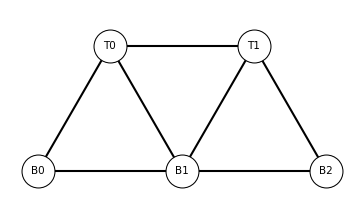

In [248]:
draw_truss(G, {L:1})

In [270]:
def add_displacements(G, prefix='u'):
    """
    For each node in G, attach a symbolic displacement vector to its attributes.
    The vector is named using the pattern: prefix_node_x and prefix_node_y.
    """
    G.graph['unknowns'] = []
    for node in G.nodes():
        if node in G.graph['fixed']:
            ux, uy = 0, 0
        else:
            ux, uy = sp.symbols(f'{prefix}_{node}_x {prefix}_{node}_y')
            G.graph['unknowns'].append(f'{prefix}_{node}_x')
            G.graph['unknowns'].append(f'{prefix}_{node}_y')

        G.nodes[node]['disp'] = sp.Matrix([ux, uy], name=f'{prefix}_{node}')

In [271]:
add_displacements(G)

# Display node positions
for node, data in G.nodes(data=True):
    display(data['disp'])

Matrix([
[0],
[0]])

Matrix([
[u_B1_x],
[u_B1_y]])

Matrix([
[0],
[0]])

Matrix([
[u_T0_x],
[u_T0_y]])

Matrix([
[u_T1_x],
[u_T1_y]])

In [253]:
def assign_material_properties(G, E, A):
    """
    Assign symbolic or constant E and A values to every edge in the graph.
    If E or A are not provided, default to symbols 'E' and 'A'.
    """
    for i, j in G.edges:
        G.edges[i, j]['E'] = E
        G.edges[i, j]['A'] = A
        
        # TODO: compute L just once


In [252]:
E, A = sp.symbols('E A')
assign_material_properties(G, E, A)

In [254]:
def edge_force_equation(G, i, j):
    """
    Return the symbolic internal force vector on node i due to node j
    through the edge (i, j), using geometry and displacement attributes.
    """
    # Node data
    x_i = G.nodes[i]['pos']
    x_j = G.nodes[j]['pos']
    u_i = G.nodes[i]['disp']
    u_j = G.nodes[j]['disp']

    # Edge properties
    edge = G.edges[i, j]
    E = edge['E']
    A = edge['A']

    # Geometry and stiffness
    r = x_j - x_i
    L = r.norm()
    P = projector(r)
    k = E * A / L

    # Internal force on node i from node j
    f_i = -k * P * (u_i - u_j)

    return f_i

In [255]:
f = edge_force_equation(G, 'B1', 'T0')
f

Matrix([
[-0.25*A*E*(u_B1_x - u_T0_x)/L + 0.25*sqrt(3)*A*E*(u_B1_y - u_T0_y)/L],
[ 0.25*sqrt(3)*A*E*(u_B1_x - u_T0_x)/L - 0.75*A*E*(u_B1_y - u_T0_y)/L]])

In [256]:
def get_node_ordering(G):
    """
    Assigns a consistent global ordering to nodes for stacking u and building K.
    Returns:
        - node_list: list of nodes in order
        - index_map: dict from node name to block index
    """
    node_list = sorted(G.nodes)  # or custom order
    index_map = {name: i for i, name in enumerate(node_list)}
    return node_list, index_map


In [257]:
def build_global_vectors(G, node_list):
    """
    Returns:
        u_global: stacked vector of unknown displacements only
        f_global: corresponding external forces
    """
    u_blocks = []
    f_blocks = []

    for node in node_list:
        u = G.nodes[node]['disp']
        f = G.nodes[node].get('f_ext', sp.Matrix([0, 0]))

        if isinstance(u[0], sp.Basic):  # symbolic, not fixed
            u_blocks.append(u)
            f_blocks.append(f)

    u_global = sp.Matrix.vstack(*u_blocks)
    f_global = sp.Matrix.vstack(*f_blocks)
    return u_global, f_global


In [258]:
def local_stiffness_block(r, k):
    """
    Returns the 4×4 local stiffness matrix for a member with direction vector r and stiffness k.
    Blocks:
        [  P  -P ]
        [ -P   P ]
    """
    P = projector(r)
    return k * sp.BlockMatrix([
        [ P, -P ],
        [ -P,  P ]
    ]).as_explicit()


In [272]:
def build_stiffness_dict(G):
    """
    For each edge, compute 2×2 stiffness contributions and accumulate into a dictionary:
    K_dict[(i, j)] = 2x2 matrix block (symbolic)
    """
    K_dict = {}

    for i, j in G.edges:
        xi, xj = G.nodes[i]['pos'], G.nodes[j]['pos']
        E, A = G.edges[i, j]['E'], G.edges[i, j]['A']
        r = xj - xi
        L = r.norm()
        P = projector(r)
        k = E * A / L

        for a, b, value in [((i, i), k*P), ((i, j), -k*P), ((j, i), -k*P), ((j, j), k*P)]:
            if (a, b) not in K_dict:
                K_dict[(a, b)] = value
            else:
                K_dict[(a, b)] += value

    return K_dict


In [273]:
def assemble_block_matrix(K_dict, node_list, fixed_nodes=()):
    """
    Assemble a BlockMatrix using entries in K_dict for non-fixed nodes only.
    """
    free_nodes = [n for n in node_list if n not in fixed_nodes]
    index_map = {n: i for i, n in enumerate(free_nodes)}
    n = len(free_nodes)

    def Z(): return sp.ImmutableMatrix.zeros(2, 2)
    blocks = [[Z() for _ in range(n)] for _ in range(n)]

    for (i, j), K_ij in K_dict.items():
        if i in fixed_nodes or j in fixed_nodes:
            continue
        a, b = index_map[i], index_map[j]
        blocks[a][b] += K_ij

    return sp.BlockMatrix(blocks), free_nodes


In [275]:
G = nx.Graph()
add_n_triangle_truss(G, N=2)
assign_material_properties(G, E, A)
add_displacements(G)
G.nodes['B1']['f_ext'] = sp.Matrix([0, -F])

In [276]:
K_dict = build_stiffness_dict(G)
K_block, free_nodes = assemble_block_matrix(K_dict, node_list, G.graph['fixed'])
K_dense = K_block.as_explicit()


ValueError: not enough values to unpack (expected 3, got 2)

In [231]:
K_dense = K_block.as_explicit()
u_global, f_global = build_global_vectors(G, node_list)
u_global

Matrix([
[u_B0_x],
[u_B0_y],
[u_B1_x],
[u_B1_y],
[u_B2_x],
[u_B2_y],
[u_T0_x],
[u_T0_y],
[u_T1_x],
[u_T1_y]])

In [232]:
f_global

Matrix([
[ 0],
[ 0],
[ 0],
[-F],
[ 0],
[ 0],
[ 0],
[ 0],
[ 0],
[ 0]])

In [233]:
eq = Eq(K_dense * u_global, f_global)
eq

Eq(Matrix([
[                                   1.25*A*E*u_B0_x/L + 0.25*sqrt(3)*A*E*u_B0_y/L - A*E*u_B1_x/L - 0.25*A*E*u_T0_x/L - 0.25*sqrt(3)*A*E*u_T0_y/L],
[                                                  0.25*sqrt(3)*A*E*u_B0_x/L + 0.75*A*E*u_B0_y/L - 0.25*sqrt(3)*A*E*u_T0_x/L - 0.75*A*E*u_T0_y/L],
[-A*E*u_B0_x/L + 2.5*A*E*u_B1_x/L - A*E*u_B2_x/L - 0.25*A*E*u_T0_x/L + 0.25*sqrt(3)*A*E*u_T0_y/L - 0.25*A*E*u_T1_x/L - 0.25*sqrt(3)*A*E*u_T1_y/L],
[                               1.5*A*E*u_B1_y/L + 0.25*sqrt(3)*A*E*u_T0_x/L - 0.75*A*E*u_T0_y/L - 0.25*sqrt(3)*A*E*u_T1_x/L - 0.75*A*E*u_T1_y/L],
[                                  -A*E*u_B1_x/L + 1.25*A*E*u_B2_x/L - 0.25*sqrt(3)*A*E*u_B2_y/L - 0.25*A*E*u_T1_x/L + 0.25*sqrt(3)*A*E*u_T1_y/L],
[                                                 -0.25*sqrt(3)*A*E*u_B2_x/L + 0.75*A*E*u_B2_y/L + 0.25*sqrt(3)*A*E*u_T1_x/L - 0.75*A*E*u_T1_y/L],
[           -0.25*A*E*u_B0_x/L - 0.25*sqrt(3)*A*E*u_B0_y/L - 0.25*A*E*u_B1_x/L + 0.25*sqrt(3)*A*E*u_B1_y/L

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)